# Heatmaps of Gamma-hurdle parameters

The gamma-hurdle distribution has three parameters, $\alpha, \beta,\ \mathrm{and\ }\lambda$. $\alpha\ \mathrm{and\ }\beta$ are estimated from the mean and standard deviation of nonzero values (`mean_nz` and `sd_nz` below), while $\lambda$, the hurdle, is estimated as the fraction of all values that are nonzero. This motivates the choices of values to plot in heatmaps below, `mean_nz`, `sd_nz`, $\lambda$ (or `p_nz`), $\alpha$, and $\beta$.

The heatmaps themselves are shown as `source_degree` by `target_degree` arrays with box colors determined by the value of the feature being shown. This makes sense because all five parameters are estimated using permuted networks. Our current method groups values from permuted networks by source and target degree, because they represent draws from the same distribution.

In [1]:
import configparser

import matplotlib.pyplot as plt
import pandas as pd
import psycopg2

In [2]:
parser = configparser.ConfigParser()
parser.read('database.ini')

db_password = parser['psql']['password']

In [3]:
def plot_feature_heatmaps(metapath):
    query = f'''
    SELECT * 
    FROM dj_hetmech_app_degreegroupedpermutation dgp
    WHERE (dgp.metapath_id='{metapath}')
    '''
    connection = psycopg2.connect(host = 'hetmech-db-dev.cobepk65dd7j.us-east-1.rds.amazonaws.com', 
                                  database = 'dj_hetmech', user = 'read_only_user', password = db_password)

    metapath_df = pd.read_sql(query, connection)

    metapath_df['p_nz'] = metapath_df['n_nonzero_dwpcs'] / metapath_df['n_dwpcs']
    metapath_df['beta'] = metapath_df['nonzero_mean'] / metapath_df['nonzero_sd']**2
    metapath_df['alpha'] = metapath_df['beta'] * metapath_df['nonzero_mean']

    # Check no duplicates so that we can use "sum" to aggregate below
    assert metapath_df.groupby(['source_degree', 'target_degree'], as_index=False).size().max() == 1

    heatmaps = {
        feature: pd.crosstab(metapath_df['source_degree'], metapath_df['target_degree'],
                             metapath_df[feature], aggfunc=sum)
        for feature in ['nonzero_mean', 'nonzero_sd', 'p_nz', 'alpha', 'beta']
    }

    for feature_name, df in heatmaps.items():
        fig, ax = plt.subplots()
        heatmap = ax.imshow(df.values)
        plt.colorbar(heatmap)
        plt.title(f'{feature_name} by degree - {metapath}')
        plt.xlabel('target degree')
        plt.ylabel('source degree')

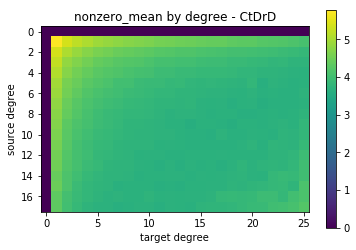

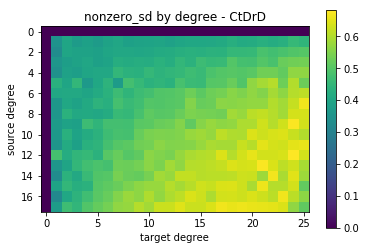

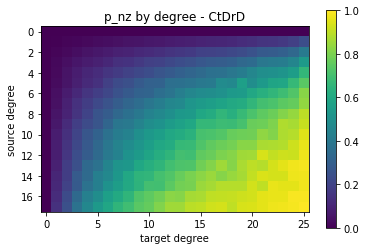

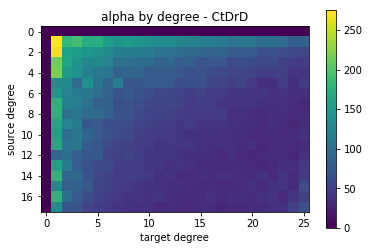

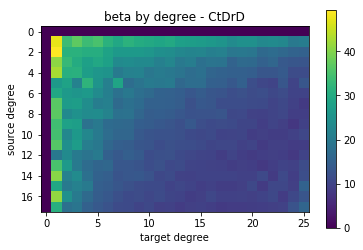

In [4]:
plot_feature_heatmaps('CtDrD')

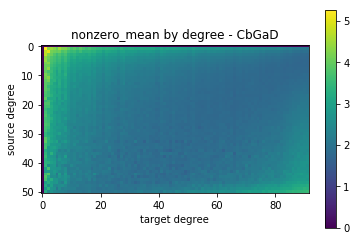

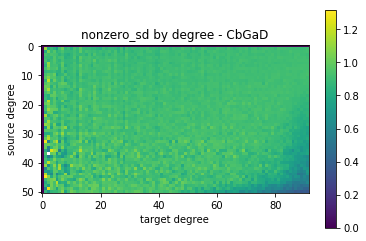

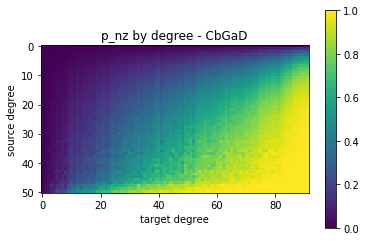

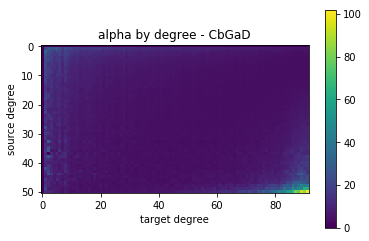

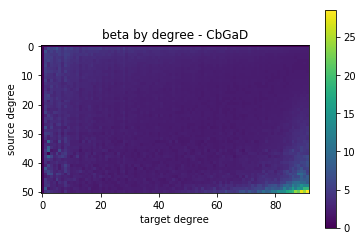

In [5]:
plot_feature_heatmaps('CbGaD')